In [5]:
import copy
import time
import pickle
import datetime
from itertools import product

import numpy as np

import matplotlib.pyplot as plt
import tqdm
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.P, J_ground=2, F1=3 / 2, F=1
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=1,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=3,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
]

polarizations = [
    [couplings.polarization_Z],
    [couplings.polarization_X, couplings.polarization_Y],
    [couplings.polarization_σm, couplings.polarization_σp],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [4]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)
v_to_Γ_μ = 0

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # J=1 -> J=2 microwaves
    Ω1=1 * hamiltonian.Γ,
    δ1=f"vx*{v_to_Γ_μ}",
    P1="sin(ω1*t + φ1)",
    PX1="P1>0",
    PY1="P1<=0",
    ω1=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # J=2 -> J=3 microwaves
    Ω2=1 * hamiltonian.Γ,
    δ2=f"vx*{v_to_Γ_μ}",
    P2="sin(ω2*t + φ2)",
    Pσm2="P2>0",
    Pσp2="P2<=0",
    ω2=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ2=0.0,  # polarization switching phase [rad]
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [6]:
tstart = time.time()
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=None,
    decay_channels=None,
    Jmax_X=4,
)
print(f"{time.time() - tstart:.1f} s running time")


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


147.6 s running time


In [11]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [12]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 3/2, F = 1>"
states,
"|X, J = 0>",0.484131
"|X, J = 2>",0.515869


In [13]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 1, F₁ = 3/2, F = 1>"
states,
"|X, J = 0, F₁ = 1/2, F = 0>",0.336757
"|X, J = 0, F₁ = 1/2, F = 1>",0.147374
"|X, J = 2, F₁ = 3/2, F = 1>",0.100763
"|X, J = 2, F₁ = 3/2, F = 2>",0.026135
"|X, J = 2, F₁ = 5/2, F = 2>",0.388971


In [14]:
from typing import Sequence, Optional
import numpy.typing as npt
from centrex_tlf.utils.population import thermal_population, J_levels


def generate_thermal_population_states(
    temperature: float,
    QN: Sequence[states.State],
    select: Optional[states.QuantumSelector] = None,
) -> npt.NDArray[np.complex_]:
    levels = len(QN)
    ρ = np.zeros([levels, levels], dtype=complex)

    assert isinstance(QN[0], states.State), "no State objects supplies"

    if select is not None:
        j_levels = np.unique(select.J)
    else:
        j_levels = np.unique(
            [
                qn.largest.J
                for qn in QN
                if qn.largest.electronic_state == states.ElectronicState.X
            ]
        )

    # get the relative thermal population fractions of the ground state
    population = dict(
        [(j, p) for j, p in zip(j_levels, thermal_population(j_levels, temperature))]
    )

    # # get quantum numbers of the ground state
    # quantum_numbers = [
    #     (qn.largest.J, qn.largest.F1, qn.largest.F, qn.largest.mF)
    #     for qn in QN
    #     if qn.largest.electronic_state == states.ElectronicState.X
    # ]

    # assert len(np.unique(quantum_numbers, axis=0)) == len(
    #     quantum_numbers
    # ), "duplicate quantum numbers"

    for idx, qn in enumerate(QN):
        if qn.largest.electronic_state is not states.ElectronicState.X:
            continue
        elif qn.largest.F is None:
            ρ[idx, idx] = population[qn.largest.J]
        else:
            ρ[idx, idx] = population[qn.largest.J] / J_levels(qn.largest.J)

    return ρ

## Indices of various collections of states

In [15]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)
indices_J0_F0 = states.QuantumSelector(
    J=0, F=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J0_F1 = states.QuantumSelector(
    J=0, F=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1_F2 = states.QuantumSelector(
    J=1, F=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2_F3 = states.QuantumSelector(
    J=2, F=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3_F4 = states.QuantumSelector(
    J=3, F=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

## Calculate Rabi rates and population density

In [16]:
ρ = generate_thermal_population_states(
    temperature=6.3,
    QN=obe_system.QN,
)
ρ /= np.trace(ρ)

In [17]:
power = 85e-3  # * 11 / 2  # 11 passes assume zero intensity left after 11 passes
intensity = power / (25.4e-3 * 25.4e-3 * 1.5)
rabi = utils.rabi.intensity_to_rabi(
    intensity, obe_system.couplings[0].main_coupling, D=2.6675506e-30
).real

rabi_microwave_12 = utils.rabi.power_to_rabi_gaussian_beam_microwave(
    power=200e-3,
    coupling=obe_system.couplings[1].main_coupling,
    sigma_x=10.8e-3,
    sigma_y=10.8e-3,
).real

rabi_microwave_23 = utils.rabi.power_to_rabi_gaussian_beam_microwave(
    power=200e-3,
    coupling=obe_system.couplings[2].main_coupling,
    sigma_x=10.8e-3,
    sigma_y=10.8e-3,
).real

## Setup and solve the OBE Problem

In [18]:
odepars.Ωl0 = rabi
odepars.Ω1 = rabi_microwave_12
odepars.ω1 = 2 * np.pi * 1e6
odepars.Ω2 = rabi_microwave_23
odepars.ω2 = 2 * np.pi * 1e6
odepars.ϕ2 = np.pi / 2

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

In [19]:
results = lindblad_julia.do_simulation_single(problem, config=config)

0.68 photons


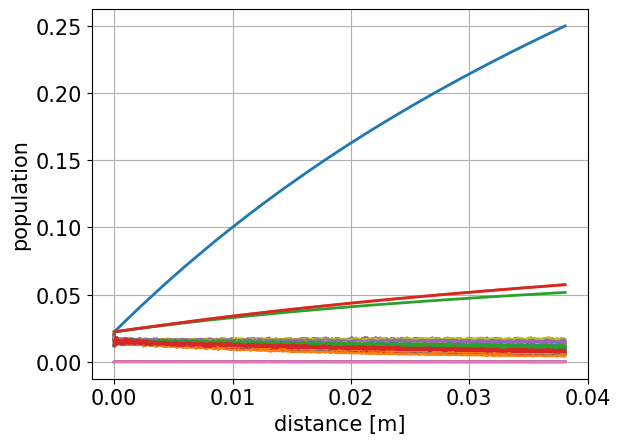

In [20]:
res = copy.deepcopy(results)

labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]
fig, ax = plt.subplots()
ax.plot(res.t * odepars.vz, res.y.T, lw=2, label=np.arange(len(res.y)))
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

# labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

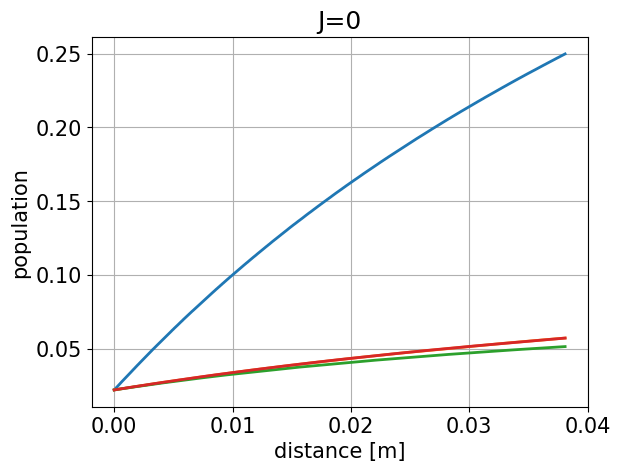

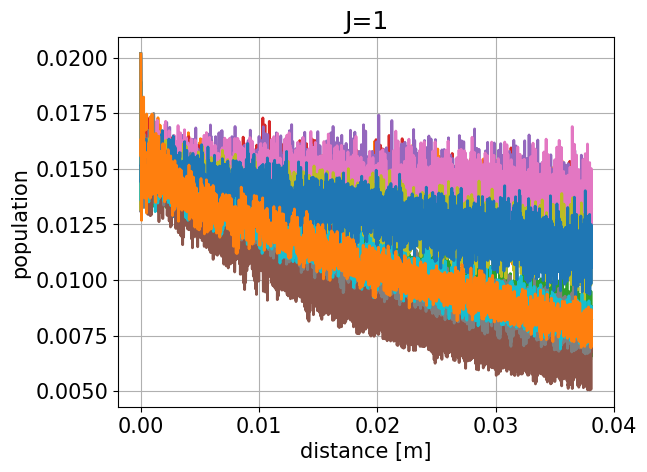

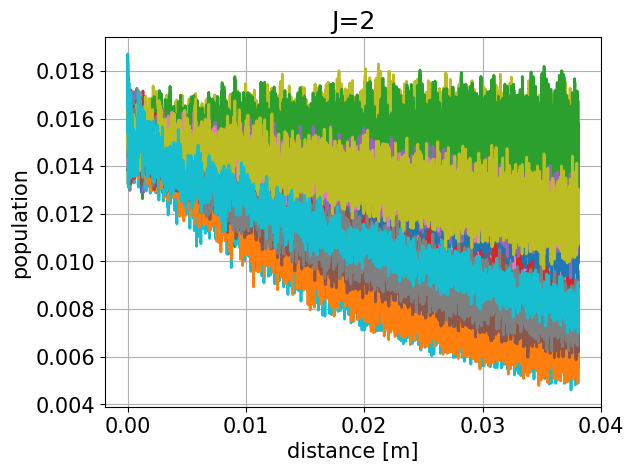

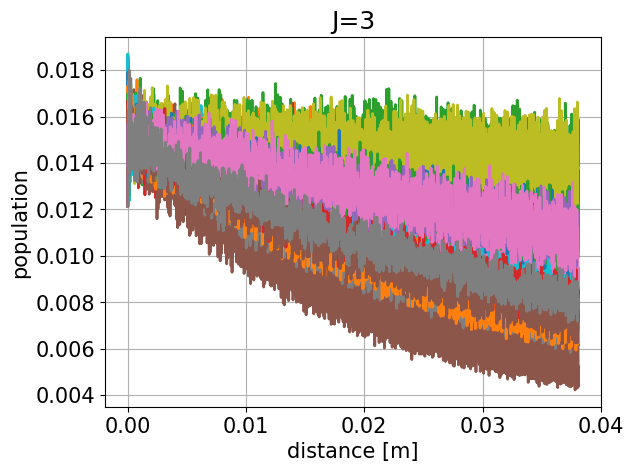

In [21]:
for J, ind in zip([0, 1, 2, 3], [indices_J0, indices_J1, indices_J2, indices_J3]):
    fig, ax = plt.subplots()
    ax.plot(res.t * odepars.vz, res.y[ind].T, lw=2)
    ax.set_xlabel("distance [m]")
    ax.set_ylabel("population")
    ax.set_title(f"J={J}")
    ax.grid(True)

In [22]:
gain_J0_F1 = (
    results.y[indices_J0_F1].sum(axis=0)[-1] / results.y[indices_J0_F1].sum(axis=0)[0]
)
gain_J0_F0 = (
    results.y[indices_J0_F0].sum(axis=0)[-1] / results.y[indices_J0_F0].sum(axis=0)[0]
)

print(f"gain J=0 F=0 from simulation → {gain_J0_F0:>4.1f}")
print(f"gain J=0 F=1 from simulation → {gain_J0_F1:>4.1f}")

gain J=0 F=0 from simulation → 11.2
gain J=0 F=1 from simulation →  2.5


In [23]:
depletion_J1_F2 = results.y[indices_J1_F2][:, -1] / results.y[indices_J1_F2][:, 0]
print(f"depletion J=1 F=2 from R(1) F=3 → {depletion_J1_F2.mean():.2f}")

depletion_J2_F3 = results.y[indices_J2_F3][:, -1] / results.y[indices_J2_F3][:, 0]
print(f"depletion J=2 F=3 from R(2) F=4 → {depletion_J2_F3.mean():.2f}")

depletion_J3_F4 = results.y[indices_J3_F4][:, -1] / results.y[indices_J3_F4][:, 0]
print(f"depletion J=3 F=4 from R(3) F=5 → {depletion_J3_F4.mean():.2f}")

depletion J=1 F=2 from R(1) F=3 → 0.46
depletion J=2 F=3 from R(2) F=4 → 0.58
depletion J=3 F=4 from R(3) F=5 → 0.74


In [24]:
depletion_J1 = results.y[indices_J1][:, -1] / results.y[indices_J1][:, 0]
print(f"depletion J=1 from simulation → {depletion_J1.mean():.2f}")

depletion_J2 = results.y[indices_J2][:, -1] / results.y[indices_J2][:, 0]
print(f"depletion J=2 from simulation → {depletion_J2.mean():.2f}")

depletion_J3 = results.y[indices_J3][:, -1] / results.y[indices_J3][:, 0]
print(f"depletion J=3 from simulation → {depletion_J3.mean():.2f}")

depletion J=1 from simulation → 0.50
depletion J=2 from simulation → 0.59
depletion J=3 from simulation → 0.79


In [25]:
br_df = couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)
br_J0_F0, br_J0_F1, *_ = br_df.values.flatten()


def gain_J0_F1_from_depletion(depletion: npt.NDArray[np.float_], T: float) -> float:
    p = thermal_population(J=np.array([0, 1, 2, 3]), T=T)
    population_to_transfer = ((depletion) * p[1:]).sum()
    factor_to_J0_F1 = br_J0_F1 / (br_J0_F1 + br_J0_F0)
    initial_population = p[0] / J_levels(0) * 3
    gain = (
        initial_population + factor_to_J0_F1 * population_to_transfer
    ) / initial_population
    return gain

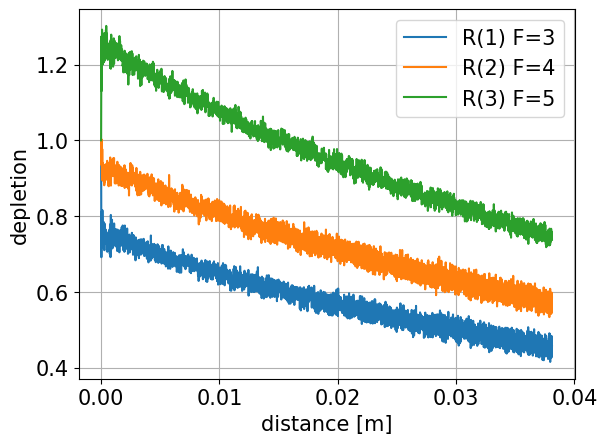

In [26]:
fig, ax = plt.subplots()

ax.plot(
    res.t * odepars.vz,
    (
        results.y[indices_J1_F2][:, :] / results.y[indices_J1_F2][:, 0][:, np.newaxis]
    ).mean(axis=0),
    label="R(1) F=3",
)
ax.plot(
    res.t * odepars.vz,
    (
        results.y[indices_J2_F3][:, :] / results.y[indices_J2_F3][:, 0][:, np.newaxis]
    ).mean(axis=0),
    label="R(2) F=4",
)
ax.plot(
    res.t * odepars.vz,
    (
        results.y[indices_J3_F4][:, :] / results.y[indices_J3_F4][:, 0][:, np.newaxis]
    ).mean(axis=0),
    label="R(3) F=5",
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("depletion")
ax.legend()
ax.grid(True)

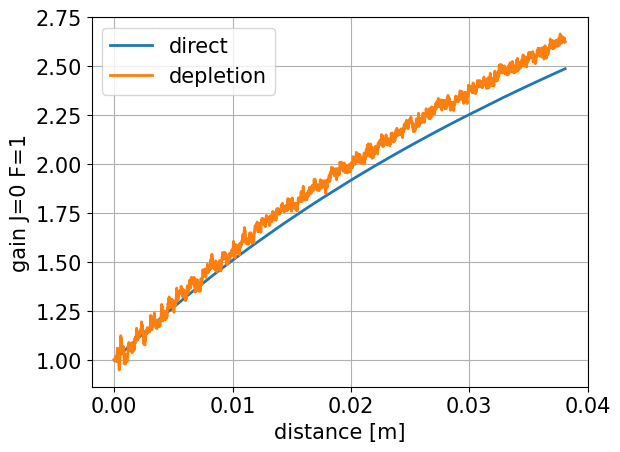

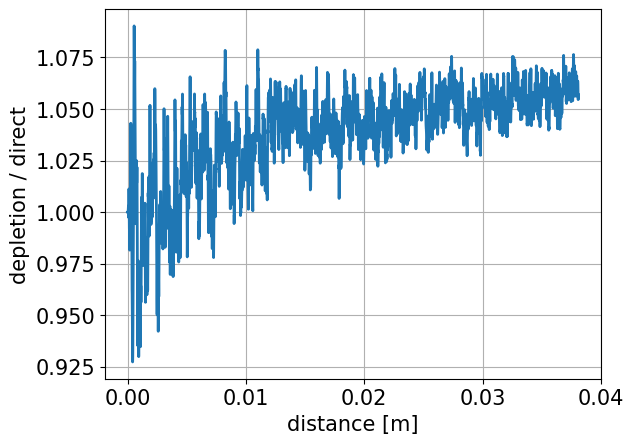

In [27]:
y1 = results.y[indices_J1_F2][:, :] / results.y[indices_J1_F2][:, 0][:, np.newaxis]
y2 = results.y[indices_J2_F3][:, :] / results.y[indices_J2_F3][:, 0][:, np.newaxis]
y3 = results.y[indices_J3_F4][:, :] / results.y[indices_J3_F4][:, 0][:, np.newaxis]

y = np.array(
    [
        gain_J0_F1_from_depletion(
            np.array(
                [
                    1 - yi1,
                    1 - yi2,
                    1 - yi3,
                ]
            ),
            T=6.3,
        )
        for yi1, yi2, yi3 in zip(y1.mean(axis=0), y2.mean(axis=0), y3.mean(axis=0))
    ]
)

direct = (
    results.y[indices_J0_F1].sum(axis=0)[:] / results.y[indices_J0_F1].sum(axis=0)[0]
)

fig, ax = plt.subplots()

ax.plot(
    res.t * odepars.vz,
    direct,
    lw=2,
    label="direct",
)
ax.plot(
    res.t * odepars.vz,
    y,
    lw=2,
    label="depletion",
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("gain J=0 F=1")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()

ax.plot(
    res.t * odepars.vz,
    y / direct,
    lw=2,
    label="depletion",
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("depletion / direct")

ax.grid(True)

In [28]:
gain_J0_F1_high_F = gain_J0_F1_from_depletion(
    np.array(
        [
            1 - depletion_J1_F2.mean(),
            1 - depletion_J2_F3.mean(),
            1 - depletion_J3_F4.mean(),
        ]
    ),
    T=6.3,
)
print(
    f"gain J=0 F=1 from depletion J=1 F=2, J=2 F=3, J=3 F=4 → {gain_J0_F1_high_F:.1f}"
)
print(f"gain J=0 F=1 from simulation → {gain_J0_F1:>4.1f}")

gain J=0 F=1 from depletion J=1 F=2, J=2 F=3, J=3 F=4 → 2.6
gain J=0 F=1 from simulation →  2.5


## Ensemble simulation for laser & microwave detuning from velocity, phase modulation and laser power

In [650]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [651]:
from julia import Main


def retrieve_results(solution: str):
    nr_solutions = Main.eval(f"size({solution})")[-1]
    res = np.array(
        [Main.eval(f"{solution}[{ids}][:]") for ids in range(1, nr_solutions + 1)]
    ).real
    return res

In [652]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.X)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

In [654]:
odepars.Ωl0 = rabi
odepars.Ω1 = rabi_microwave_12
odepars.ω1 = 2 * np.pi * 1e6
odepars.Ω2 = rabi_microwave_23
odepars.ω2 = 2 * np.pi * 1e6
odepars.ϕ2 = np.pi / 2
odepars.vz = 184

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

In [681]:
velocities_x = np.linspace(-5, 5, 21)
betas = np.linspace(0, 5, 11)
rabis_laser = np.linspace(0, 1, 8) * hamiltonian.Γ

T = 7.5

ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, save_everystep=False
)


ρ = generate_thermal_population_states(
    temperature=T,
    QN=obe_system.QN,
)
ρ /= np.trace(ρ)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))

scan_values = [rabis_laser, velocities_x, betas]
parameters = ["Ωl0", "vx", "β"]

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

results = retrieve_results("sol")

results_power_detuning_betas = results.reshape(
    betas.size, velocities_x.size, rabis_laser.size, *results.shape[-2:]
)

In [ ]:
t_file = datetime.datetime.now().replace(microsecond=0).isoformat().replace(":", "_")

with open(f"P2_microwaves_J1_J2_J3_{t_file}.pkl", "wb") as f:
    pickle.dump(
        (
            rabis_laser,
            velocities_x,
            betas,
            results_power_detuning_betas,
        ),
        f,
    )

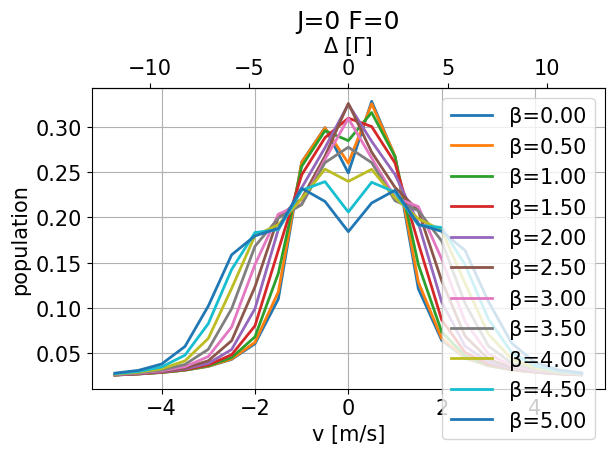

In [700]:
def detuning_to_velocity(Δ: float) -> float:
    return Δ / (utils.detuning.velocity_to_detuning(1))


fig, ax = plt.subplots()

for idb, β in enumerate(betas):
    ax.plot(
        velocities_x,
        results_detuning[idb, :, -1, indices_J0_F0].flatten(),
        lw=2,
        label=f"{β=:.2f}",
    )
    # ax.plot(
    #     velocities_x,
    #     results_detuning[idb, :, -1, indices_J0_F1].T,
    #     lw=2,
    #     label="J=0 F=1",
    # )

ax1 = ax.secondary_xaxis(
    "top",
    functions=(
        lambda x: utils.detuning.velocity_to_detuning(x) / hamiltonian.Γ,
        lambda x: detuning_to_velocity(x) * hamiltonian.Γ,
    ),
)

ax.set_xlabel("v [m/s]")
ax.set_ylabel("population")
ax1.set_xlabel("Δ [Γ]")

ax.set_title("J=0 F=0")

ax.legend()

fig.tight_layout()
ax.grid(True)

## Ensemble Simulation with temperature, laser and microwave power

In [307]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.X)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

In [309]:
rabis_laser = np.linspace(0, 1, 8) * hamiltonian.Γ
rabis_microwave_12 = np.linspace(0, 1.5, 11) * hamiltonian.Γ
rabis_microwave_23 = np.linspace(0, 1.5, 12) * hamiltonian.Γ

Ts = np.linspace(4, 18, 5)

ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, save_everystep=False
)


results_temperature_power = []
for T in tqdm.tqdm(Ts):
    ρ = generate_thermal_population_states(
        temperature=T,
        QN=obe_system.QN,
    )
    ρ /= np.trace(ρ)

    problem = lindblad_julia.OBEProblem(
        odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz)
    )

    scan_values = [rabis_laser, rabis_microwave_12, rabis_microwave_23]
    parameters = ["Ωl0", "Ω1", "Ω2"]

    ensemble_problem = lindblad_julia.OBEEnsembleProblem(
        problem=problem,
        parameters=parameters,
        scan_values=scan_values,
    )

    lindblad_julia.setup_problem_parameter_scan(
        ensemble_problem,
    )

    lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

    results = retrieve_results("sol")

    results_temperature_power.append(
        results.reshape(
            rabis_microwave_23.size,
            rabis_microwave_12.size,
            rabis_laser.size,
            *results.shape[-2:],
        )
    )

results_temperature_power = np.array(results_temperature_power)

100%|██████████| 5/5 [3:24:17<00:00, 2451.53s/it]  


In [310]:
t_file = datetime.datetime.now().replace(microsecond=0).isoformat().replace(":", "_")

with open(f"P2_microwaves_J1_J2_J3_{t_file}.pkl", "wb") as f:
    pickle.dump(
        (
            Ts,
            rabis_laser,
            rabis_microwave_12,
            rabis_microwave_23,
            results_temperature_power,
        ),
        f,
    )

## Analysis of Ensemble Simulation

In [487]:
depletion_J1_F2 = (
    results_temperature_power[:, :, :, :, -1, indices_J1_F2]
    / results_temperature_power[:, :, :, :, 0, indices_J1_F2]
)
depletion_J2_F3 = (
    results_temperature_power[:, :, :, :, -1, indices_J2_F3]
    / results_temperature_power[:, :, :, :, 0, indices_J2_F3]
)
depletion_J3_F4 = (
    results_temperature_power[:, :, :, :, -1, indices_J3_F4]
    / results_temperature_power[:, :, :, :, 0, indices_J3_F4]
)
depletion_J1 = (
    results_temperature_power[:, :, :, :, -1, indices_J1]
    / results_temperature_power[:, :, :, :, 0, indices_J1]
)
depletion_J2 = (
    results_temperature_power[:, :, :, :, -1, indices_J2]
    / results_temperature_power[:, :, :, :, 0, indices_J2]
)
depletion_J3 = (
    results_temperature_power[:, :, :, :, -1, indices_J3]
    / results_temperature_power[:, :, :, :, 0, indices_J3]
)
gain_J0_F1 = (
    results_temperature_power[:, :, :, :, -1, indices_J0_F1]
    / results_temperature_power[:, :, :, :, 0, indices_J0_F1]
)
gain_J0_F0 = (
    results_temperature_power[:, :, :, :, -1, indices_J0_F0]
    / results_temperature_power[:, :, :, :, 0, indices_J0_F0]
)

## Gain J=0 F=1

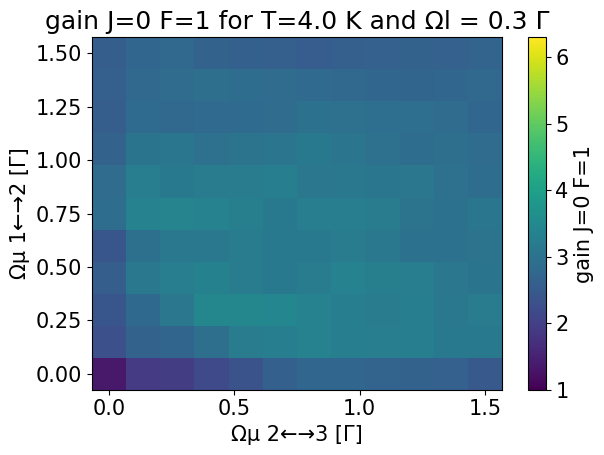

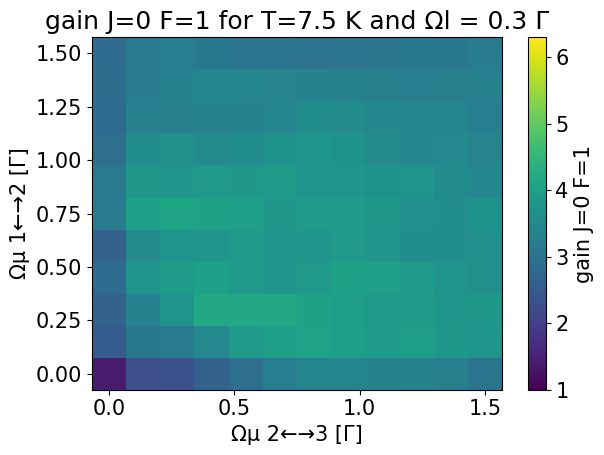

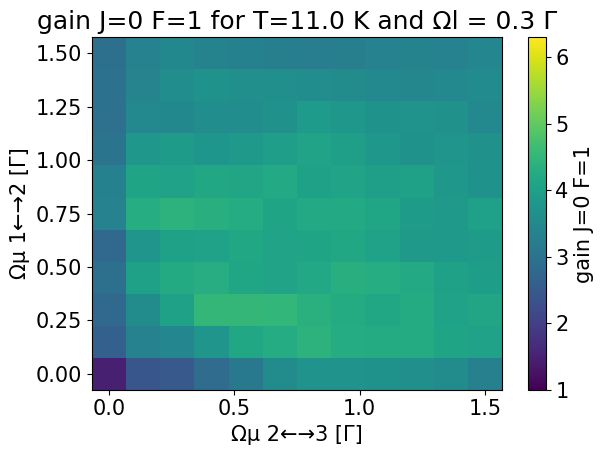

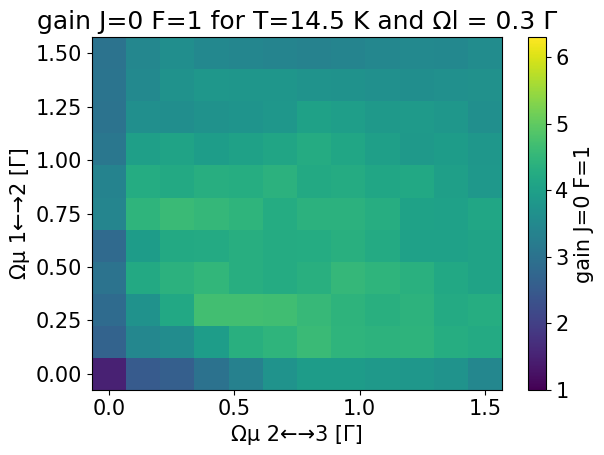

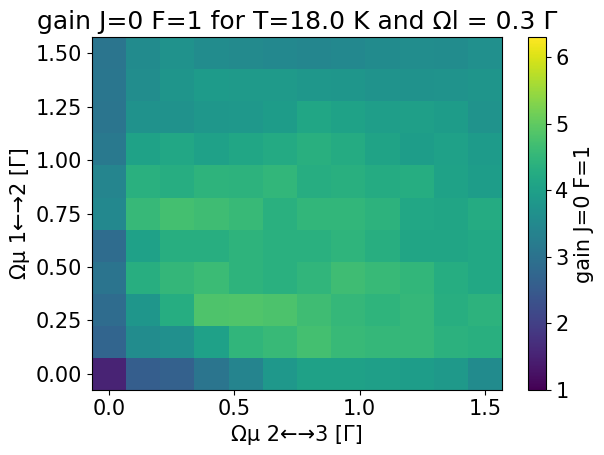

In [488]:
idL = 2

X, Y = np.meshgrid(rabis_microwave_23, rabis_microwave_12, indexing="ij")

for idT, Ti in enumerate(Ts):
    # if idT % 2 == 0:
    #     continue

    data = gain_J0_F1.mean(axis=-1)[idT, :, :, idL]

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, data, vmin=1, vmax=6.3)
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("gain J=0 F=1")
    ax.set_xlabel("Ωμ 2←→3 [Γ]")
    ax.set_ylabel("Ωμ 1←→2 [Γ]")
    ax.set_title(
        f"gain J=0 F=1 for T={Ti:.1f} K and Ωl = {rabis_laser[idL]/hamiltonian.Γ:.1f} Γ"
    )
    fig.tight_layout()
    # ax.grid(True)

## Gain from depletions in J=1 F=2 and J=2 F=3, J=3 F=4 vs actual gain

In [489]:
import itertools

gain_from_depletion_high_F = np.empty(gain_J0_F1.shape[:-1], dtype=np.float64)

for i, j, k, l in itertools.product(*[range(v) for v in gain_J0_F1.shape[:-1]]):
    dep = np.array(
        [
            1 - depletion_J1_F2.mean(axis=-1)[i, j, k, l],
            1 - depletion_J2_F3.mean(axis=-1)[i, j, k, l],
            1 - depletion_J3_F4.mean(axis=-1)[i, j, k, l],
        ]
    )
    gain_from_depletion_high_F[i, j, k, l] = gain_J0_F1_from_depletion(
        depletion=dep, T=Ts[i]
    )

gain_from_depletion = np.empty(gain_J0_F1.shape[:-1])

for i, j, k, l in itertools.product(*[range(v) for v in gain_J0_F1.shape[:-1]]):
    dep = np.array(
        [
            1 - depletion_J1.mean(axis=-1)[i, j, k, l],
            1 - depletion_J2.mean(axis=-1)[i, j, k, l],
            1 - depletion_J3.mean(axis=-1)[i, j, k, l],
        ]
    )
    gain_from_depletion[i, j, k, l] = gain_J0_F1_from_depletion(depletion=dep, T=Ts[i])

Ωl = 0.29 Γ
Ωμ12 = 0.90 Γ
Ωμ23 = 0.27 Γ


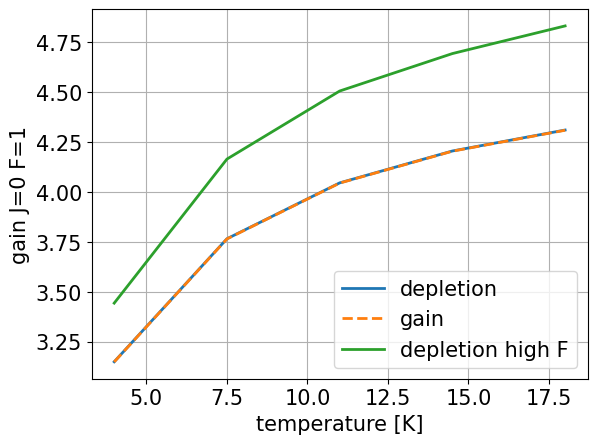

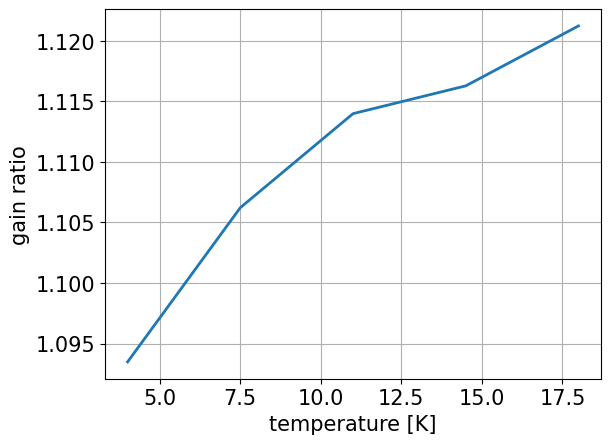

In [490]:
idx_mu_12, idx_mu_23, idx_laser = 6, 2, 2

print(f"Ωl = {rabis_laser[idx_laser]/hamiltonian.Γ:.2f} Γ")
print(f"Ωμ12 = {rabis_microwave_12[idx_mu_12]/hamiltonian.Γ:.2f} Γ")
print(f"Ωμ23 = {rabis_microwave_23[idx_mu_23]/hamiltonian.Γ:.2f} Γ")

fig, ax = plt.subplots()

ax.plot(
    Ts, gain_from_depletion[:, idx_mu_23, idx_mu_12, idx_laser], label="depletion", lw=2
)
ax.plot(
    Ts,
    gain_J0_F1[:, idx_mu_23, idx_mu_12, idx_laser].mean(axis=-1),
    label="gain",
    ls="--",
    lw=2,
)
ax.plot(
    Ts,
    gain_from_depletion_high_F[:, idx_mu_23, idx_mu_12, idx_laser],
    label="depletion high F",
    lw=2,
)
ax.set_xlabel("temperature [K]")
ax.set_ylabel("gain J=0 F=1")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()

ax.plot(
    Ts,
    gain_from_depletion_high_F[:, idx_mu_23, idx_mu_12, idx_laser]
    / gain_J0_F1[:, idx_mu_23, idx_mu_12, idx_laser].mean(axis=-1),
    lw=2,
)
ax.set_xlabel("temperature [K]")
ax.set_ylabel("gain ratio")
ax.grid(True)

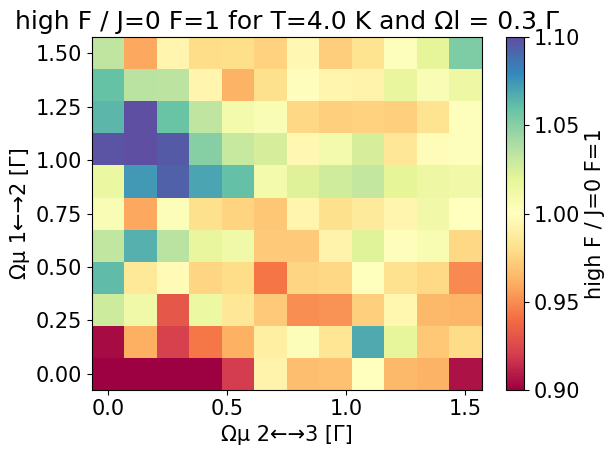

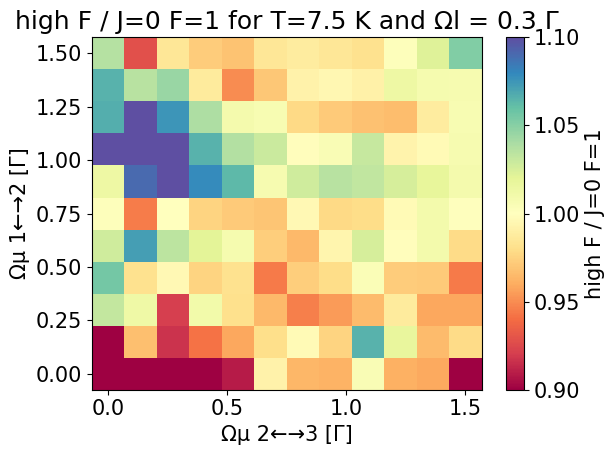

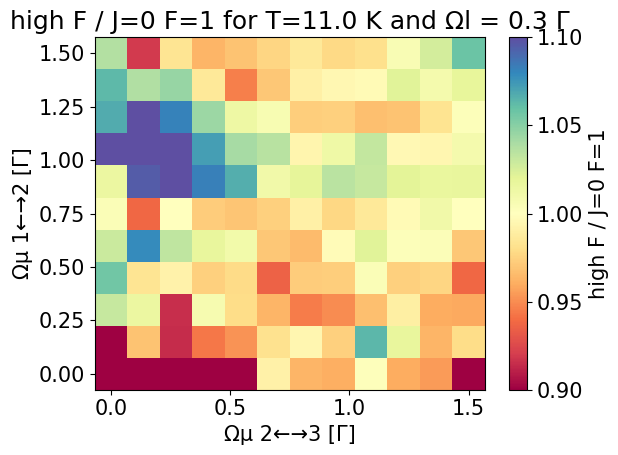

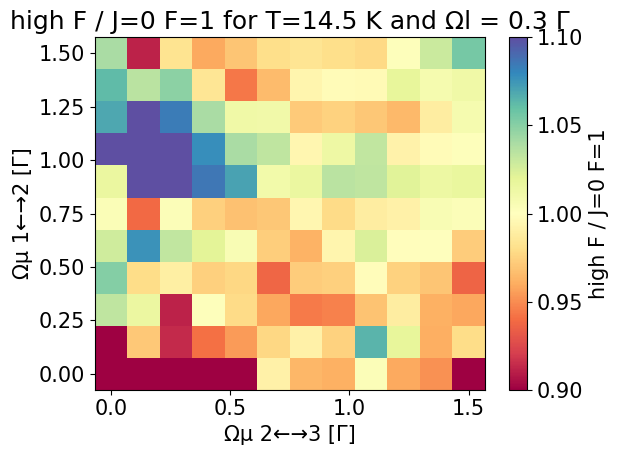

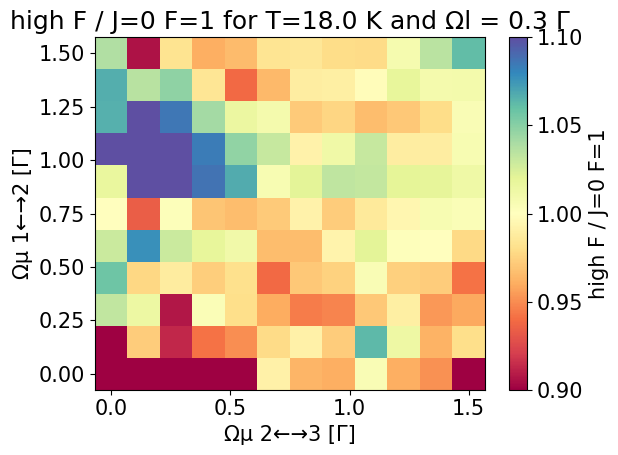

In [491]:
from matplotlib import colors

divnorm = colors.TwoSlopeNorm(vmin=0.9, vcenter=1, vmax=1.1)

idL = 2

X, Y = np.meshgrid(rabis_microwave_23, rabis_microwave_12, indexing="ij")

for idT, Ti in enumerate(Ts):
    # if idT % 2 == 0:
    #     continue

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(
        X / hamiltonian.Γ,
        Y / hamiltonian.Γ,
        (
            gain_from_depletion_high_F[idT, :, :, idL]
            / gain_J0_F1[idT, :, :, idL].mean(axis=-1)
        ),
        norm=divnorm,
        cmap="Spectral",
    )
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("high F / J=0 F=1")
    ax.set_xlabel("Ωμ 2←→3 [Γ]")
    ax.set_ylabel("Ωμ 1←→2 [Γ]")
    ax.set_title(
        f"high F / J=0 F=1 for T={Ti:.1f} K and Ωl ="
        f" {rabis_laser[idL]/hamiltonian.Γ:.1f} Γ"
    )
    fig.tight_layout()
    # ax.grid(True)

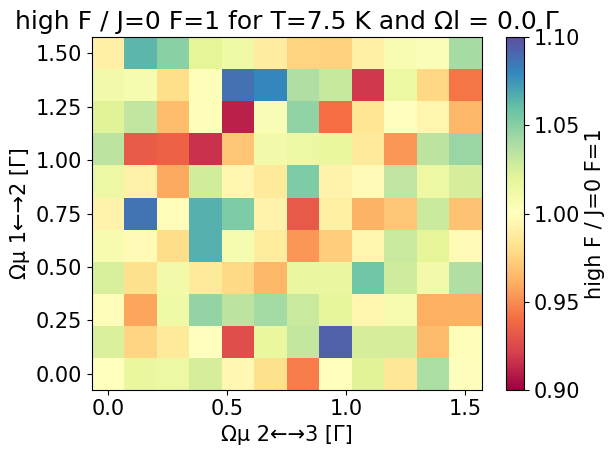

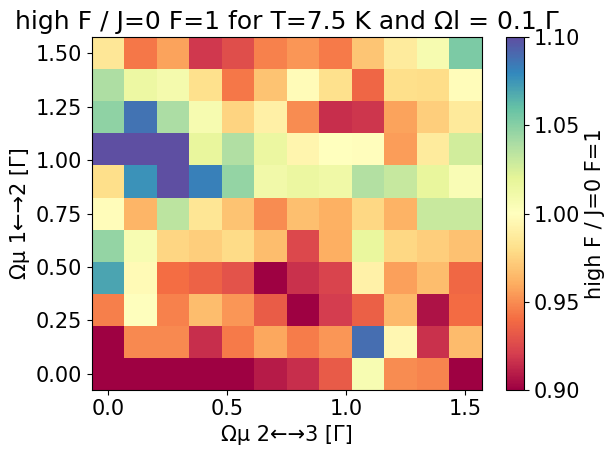

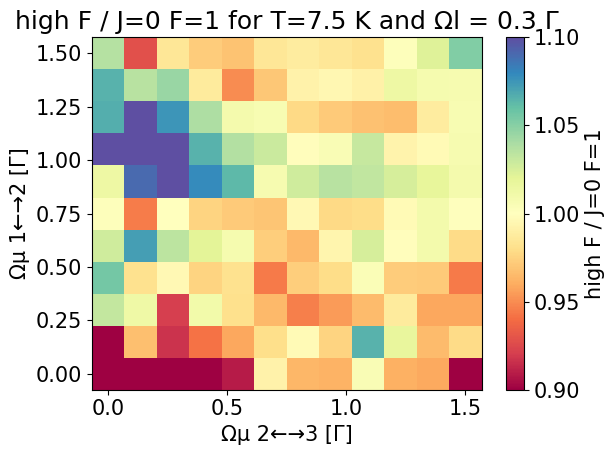

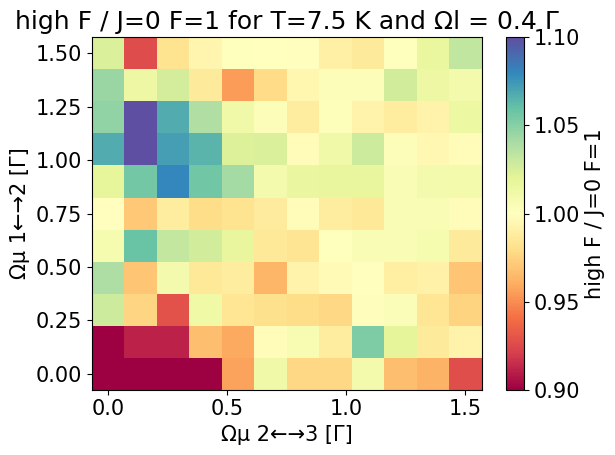

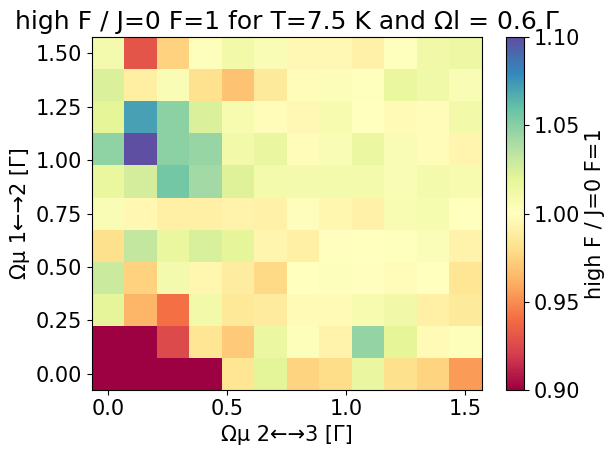

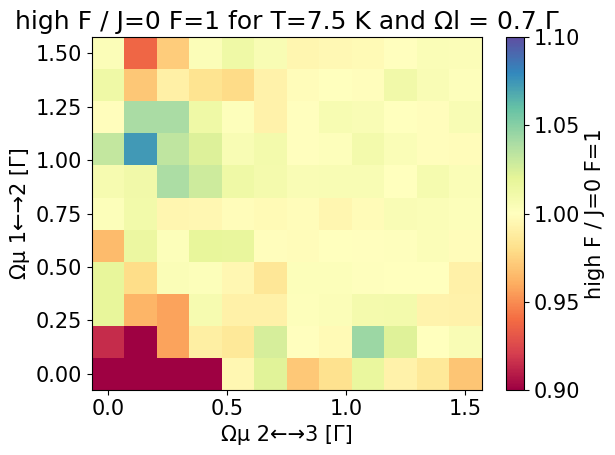

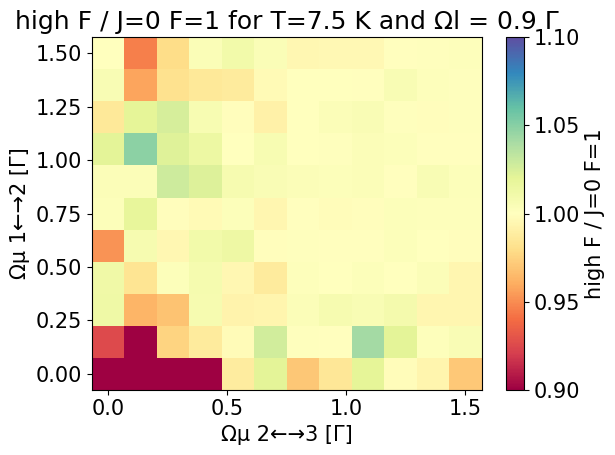

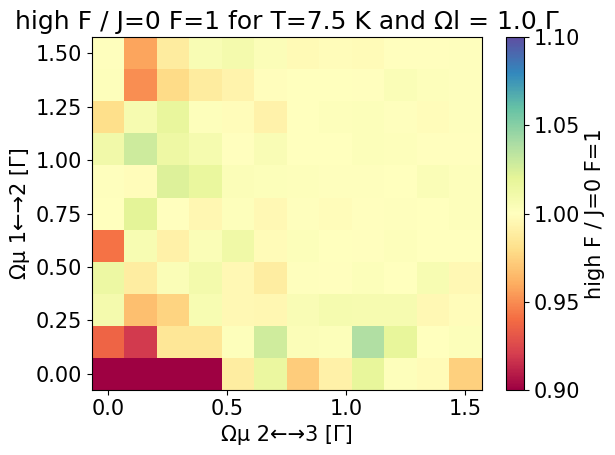

In [493]:
from matplotlib import colors

divnorm = colors.TwoSlopeNorm(vmin=0.9, vcenter=1, vmax=1.1)

idT = 1

X, Y = np.meshgrid(rabis_microwave_23, rabis_microwave_12, indexing="ij")

for idL, Ωl in enumerate(rabis_laser):
    # if idT % 2 == 0:
    #     continue

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(
        X / hamiltonian.Γ,
        Y / hamiltonian.Γ,
        (
            gain_from_depletion_high_F[idT, :, :, idL]
            / gain_J0_F1[idT, :, :, idL].mean(axis=-1)
        ),
        norm=divnorm,
        cmap="Spectral",
    )
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("high F / J=0 F=1")
    ax.set_xlabel("Ωμ 2←→3 [Γ]")
    ax.set_ylabel("Ωμ 1←→2 [Γ]")
    ax.set_title(
        f"high F / J=0 F=1 for T={Ts[idT]:.1f} K and Ωl ="
        f" {rabis_laser[idL]/hamiltonian.Γ:.1f} Γ"
    )
    fig.tight_layout()
    # ax.grid(True)

## Depletion

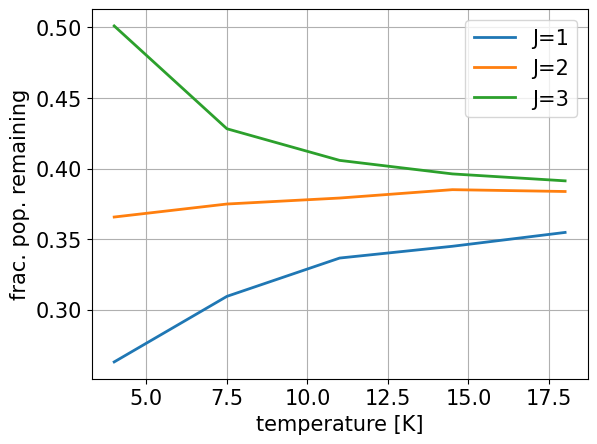

In [ ]:
idx_mu_12, idx_mu_23, idx_laser = 2, 2, 2

fig, ax = plt.subplots()

ax.plot(
    Ts,
    depletion_J1.mean(axis=-1)[:, idx_mu_23, idx_mu_12, idx_laser],
    lw=2,
    label="J=1",
)
ax.plot(
    Ts,
    depletion_J2.mean(axis=-1)[:, idx_mu_23, idx_mu_12, idx_laser],
    lw=2,
    label="J=2",
)
ax.plot(
    Ts,
    depletion_J3.mean(axis=-1)[:, idx_mu_23, idx_mu_12, idx_laser],
    lw=2,
    label="J=3",
)
ax.set_xlabel("temperature [K]")
ax.set_ylabel("frac. pop. remaining")
ax.legend()
ax.grid(True)

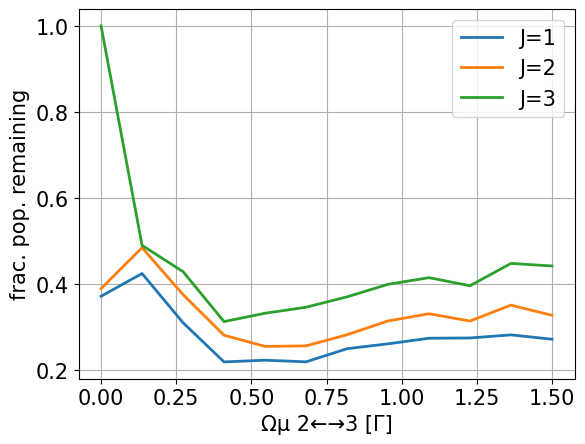

In [ ]:
idT = 1

fig, ax = plt.subplots()

ax.plot(
    rabis_microwave_23 / hamiltonian.Γ,
    depletion_J1.mean(axis=-1)[idT, :, idx_mu_12, idx_laser],
    lw=2,
    label="J=1",
)
ax.plot(
    rabis_microwave_23 / hamiltonian.Γ,
    depletion_J2.mean(axis=-1)[idT, :, idx_mu_12, idx_laser],
    lw=2,
    label="J=2",
)
ax.plot(
    rabis_microwave_23 / hamiltonian.Γ,
    depletion_J3.mean(axis=-1)[idT, :, idx_mu_12, idx_laser],
    lw=2,
    label="J=3",
)
ax.set_xlabel("Ωμ 2←→3 [Γ]")
ax.set_ylabel("frac. pop. remaining")
ax.legend()
ax.grid(True)

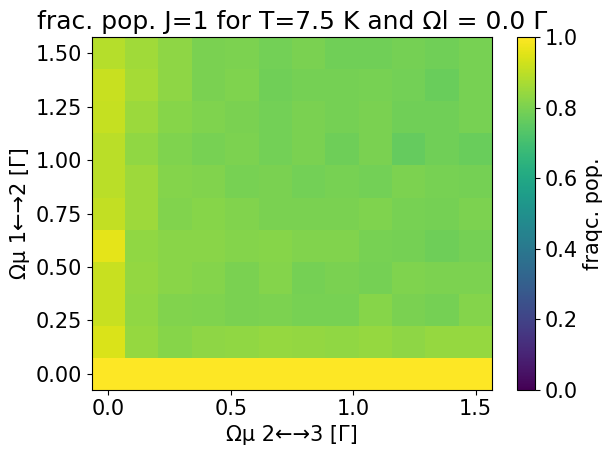

In [ ]:
X, Y = np.meshgrid(rabis_microwave_23, rabis_microwave_12, indexing="ij")

for idL, Ωl in enumerate(rabis_laser):
    # if idT % 2 == 0:
    #     continue

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(
        X / hamiltonian.Γ,
        Y / hamiltonian.Γ,
        depletion_J1.mean(axis=-1)[idT, :, :, idL],
        vmin=0,
        vmax=1,
    )
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("fraqc. pop.")
    ax.set_xlabel("Ωμ 2←→3 [Γ]")
    ax.set_ylabel("Ωμ 1←→2 [Γ]")
    ax.set_title(
        f"frac. pop. J=1 for T={Ts[idT]:.1f} K and Ωl ="
        f" {rabis_laser[idL]/hamiltonian.Γ:.1f} Γ"
    )
    fig.tight_layout()
    break

## Plots of Rabi Rates and Power

FWHM = $2\sqrt{2\ln2}σ = 2.355σ$
microwaves have a FWHM of about 1" (from Oskari's thesis, page 219), i.e. $σ = 10.8$ mm

power -> intensity -$\sqrt{}$-> electric field -> rabi

An intensity profile converts to a Rabi rate by multiplying σ with $\sqrt{2}$, but only matters when simulation the full gaussian beam profile.

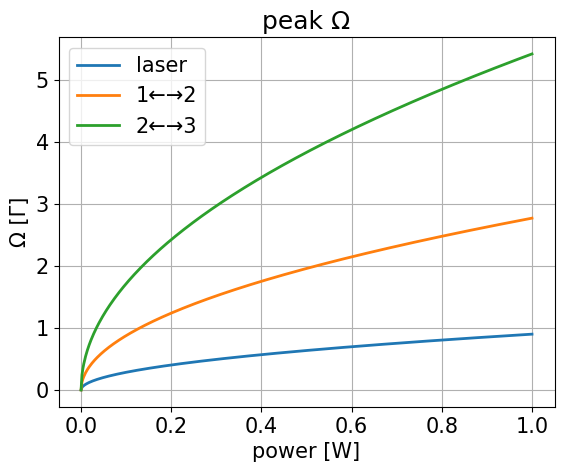

In [320]:
powers = np.linspace(0, 1, 501)

fig, ax = plt.subplots()
ax.plot(
    powers,
    -utils.rabi.intensity_to_rabi(
        (powers / (25.4e-3 * 25.4e-3 * 1.5)),
        obe_system.couplings[0].main_coupling,
        D=2.6675506e-30,
    ).real
    / hamiltonian.Γ,
    lw=2,
    label="laser",
)
ax.plot(
    powers,
    -utils.rabi.power_to_rabi_gaussian_beam_microwave(
        power=powers,
        coupling=obe_system.couplings[1].main_coupling,
        sigma_x=10.8e-3,
        sigma_y=10.8e-3,
    ).real
    / hamiltonian.Γ,
    lw=2,
    label="1←→2",
)
ax.plot(
    powers,
    -utils.rabi.power_to_rabi_gaussian_beam_microwave(
        power=powers,
        coupling=obe_system.couplings[2].main_coupling,
        sigma_x=10.8e-3,
        sigma_y=10.8e-3,
    ).real
    / hamiltonian.Γ,
    lw=2,
    label="2←→3",
)
ax.set_xlabel("power [W]")
ax.set_ylabel("Ω [Γ]")
ax.set_title("peak Ω")
ax.legend()
ax.grid(True)

Note that this gives the microwave Rabi rate at the peak intensity of the gaussian, whereas this simulation only includes a constant rabi rate. The effective rabi rate is thus lower.

For the laser it assumes an uniform distribution of the power over 1" by $\sqrt{2}\cdot1.5$", which in reality is multipassed between to prisms. Assuming a loss of 15% per pass, and 11 passes, we'd have about 470 mW over 1" by $\sqrt{2}⋅1$", a Ω of about 3Γ/4.

## Ensemble for 7.5 K with different velocities

In [617]:
rabis_laser = np.linspace(0, 1, 8) * hamiltonian.Γ
rabis_microwave_12 = np.linspace(0, 1.5, 11) * hamiltonian.Γ
rabis_microwave_23 = np.linspace(0, 1.5, 12) * hamiltonian.Γ
velocities = np.linspace(184 - 16 * 2, 184 + 16 * 2, 9)
T = 7.5

stop = lindblad_julia.setup_discrete_callback_terminate(
    odepars=odepars, stop_expression="vz*t >= 1.5*25.4e-3"
)

ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, save_everystep=False, callback=stop
)


ρ = generate_thermal_population_states(
    temperature=T,
    QN=obe_system.QN,
)
ρ /= np.trace(ρ)

problem = lindblad_julia.OBEProblem(
    odepars, ρ, tspan=(0, 25.4e-3 * 2 / velocities.min())
)

scan_values = [rabis_laser, rabis_microwave_12, rabis_microwave_23, velocities]
parameters = ["Ωl0", "Ω1", "Ω2", "vz"]

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

results = retrieve_results("sol")

results_temperature_power_velocity = results.reshape(
    velocities.size,
    rabis_microwave_23.size,
    rabis_microwave_12.size,
    rabis_laser.size,
    *results.shape[-2:],
)

KeyboardInterrupt: 

In [624]:
t_file = datetime.datetime.now().replace(microsecond=0).isoformat().replace(":", "_")

print(f"P2_microwaves_J1_J2_J3_with_velocity_{t_file}.pkl")

with open(f"P2_microwaves_J1_J2_J3_with_velocity_{t_file}.pkl", "wb") as f:
    pickle.dump(
        (
            T,
            rabis_laser,
            rabis_microwave_12,
            rabis_microwave_23,
            velocities,
            results_temperature_power_velocity,
        ),
        f,
    )

P2_microwaves_J1_J2_J3_with_velocity_2023-10-13T19_01_07.pkl


## Convolve with velocities

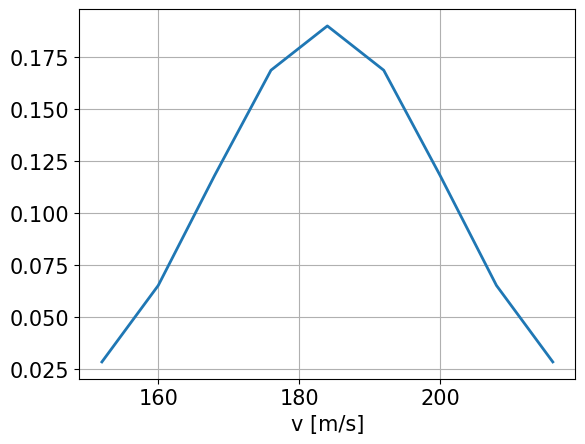

In [625]:
from scipy import stats

dist = stats.norm(loc=184, scale=16.4).pdf(velocities)
# 2 sigma, so 95% of all velocities between those
dist /= dist.sum()
dist *= 0.95

fig, ax = plt.subplots()
ax.plot(velocities, dist, lw=2)
ax.set_xlabel("v [m/s]")
ax.grid(True)

In [626]:
dat_einsum = np.einsum("i,ijklmn -> jklmn", dist, results_temperature_power_velocity)[
    :, :, :, :, :
]

In [632]:
dat = np.empty(
    list(results_temperature_power_velocity.shape[1:-2])
    + list(results_temperature_power_velocity.shape[-2:]),
    dtype=np.float64,
)
for i, j, k in product(
    *[range(v) for v in results_temperature_power_velocity.shape[1:-2]]
):
    val = 0
    for idv, v_fraction in enumerate(dist):
        val += results_temperature_power_velocity[idv, i, j, k] * v_fraction
    dat[i, j, k] = val

In [635]:
depletion_J1_F2 = dat[:, :, :, -1, indices_J1_F2] / dat[:, :, :, 0, indices_J1_F2]
depletion_J2_F3 = dat[:, :, :, -1, indices_J2_F3] / dat[:, :, :, 0, indices_J2_F3]
depletion_J3_F4 = dat[:, :, :, -1, indices_J3_F4] / dat[:, :, :, 0, indices_J3_F4]
depletion_J1 = dat[:, :, :, -1, indices_J1] / dat[:, :, :, 0, indices_J1]
depletion_J2 = dat[:, :, :, -1, indices_J2] / dat[:, :, :, 0, indices_J2]
depletion_J3 = dat[:, :, :, -1, indices_J3] / dat[:, :, :, 0, indices_J3]
gain_J0_F1 = dat[:, :, :, -1, indices_J0_F1] / dat[:, :, :, 0, indices_J0_F1]
gain_J0_F0 = dat[:, :, :, -1, indices_J0_F0] / dat[:, :, :, 0, indices_J0_F0]

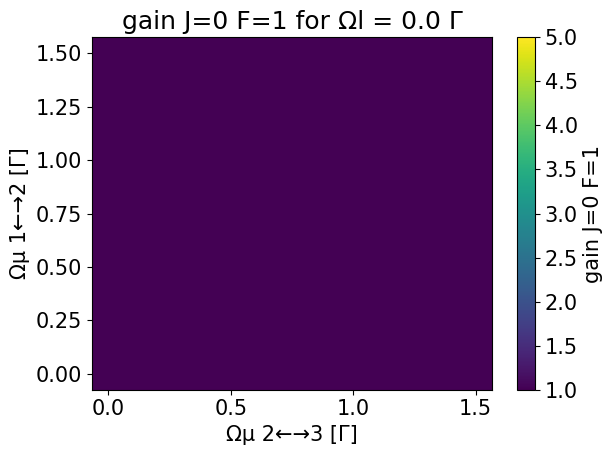

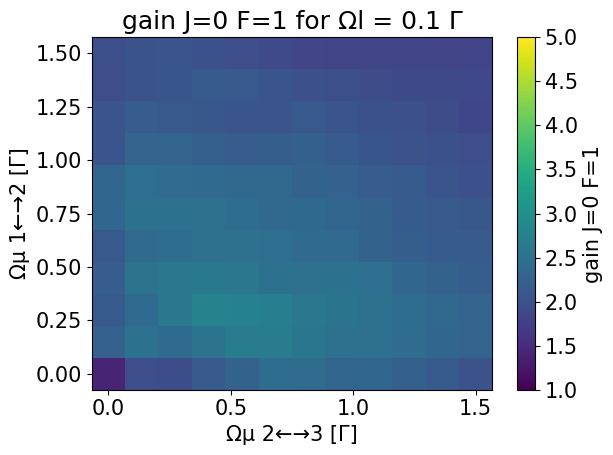

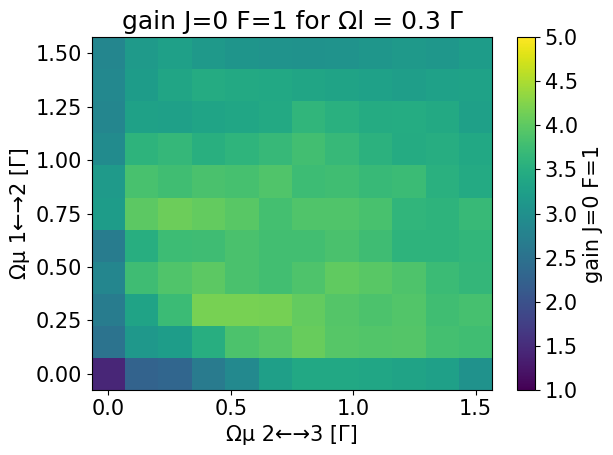

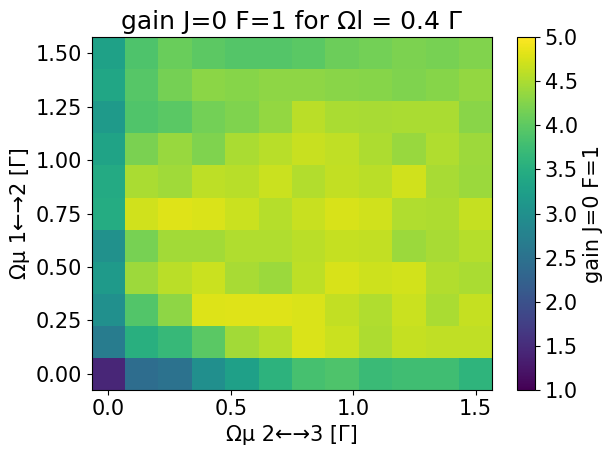

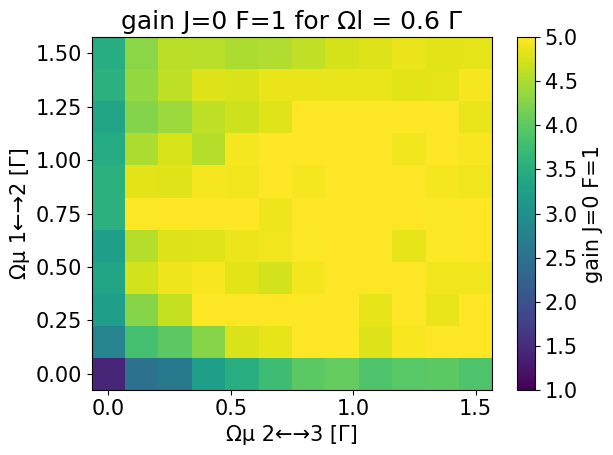

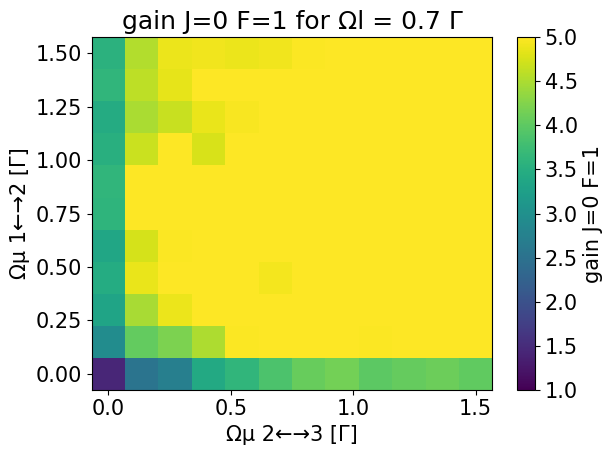

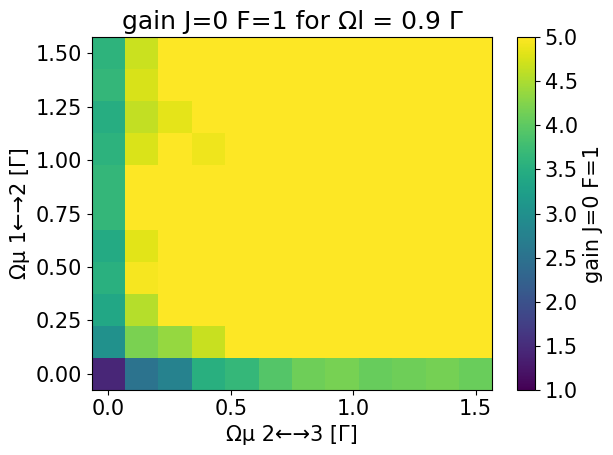

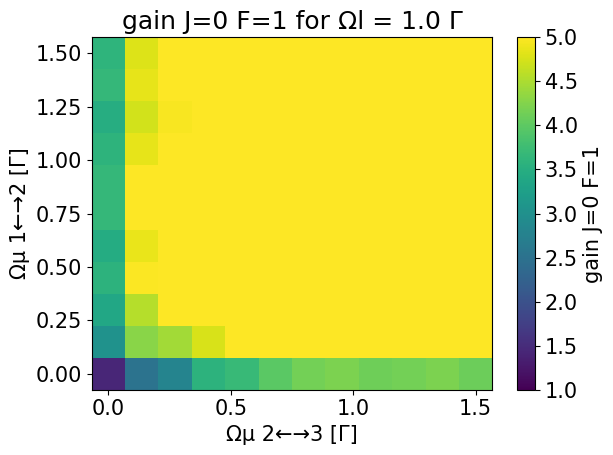

In [636]:
X, Y = np.meshgrid(rabis_microwave_23, rabis_microwave_12, indexing="ij")

for idL, Ωl in enumerate(rabis_laser):
    # if idT % 2 == 0:
    #     continue

    data = gain_J0_F1.mean(axis=-1)[:, :, idL]

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, data, vmin=1, vmax=5)
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("gain J=0 F=1")
    ax.set_xlabel("Ωμ 2←→3 [Γ]")
    ax.set_ylabel("Ωμ 1←→2 [Γ]")
    ax.set_title(f"gain J=0 F=1 for Ωl = {rabis_laser[idL]/hamiltonian.Γ:.1f} Γ")
    fig.tight_layout()
    # ax.grid(True)

In [641]:
import itertools

gain_from_depletion_high_F = np.empty(gain_J0_F1.shape[:-1], dtype=np.float64)

for i, j, k in itertools.product(*[range(v) for v in gain_J0_F1.shape[:-1]]):
    dep = np.array(
        [
            1 - depletion_J1_F2.mean(axis=-1)[i, j, k],
            1 - depletion_J2_F3.mean(axis=-1)[i, j, k],
            1 - depletion_J3_F4.mean(axis=-1)[i, j, k],
        ]
    )
    gain_from_depletion_high_F[i, j, k] = gain_J0_F1_from_depletion(
        depletion=dep, T=7.5
    )

gain_from_depletion = np.empty(gain_J0_F1.shape[:-1])

for i, j, k in itertools.product(*[range(v) for v in gain_J0_F1.shape[:-1]]):
    dep = np.array(
        [
            1 - depletion_J1.mean(axis=-1)[i, j, k],
            1 - depletion_J2.mean(axis=-1)[i, j, k],
            1 - depletion_J3.mean(axis=-1)[i, j, k],
        ]
    )
    gain_from_depletion[i, j, k] = gain_J0_F1_from_depletion(depletion=dep, T=7.5)

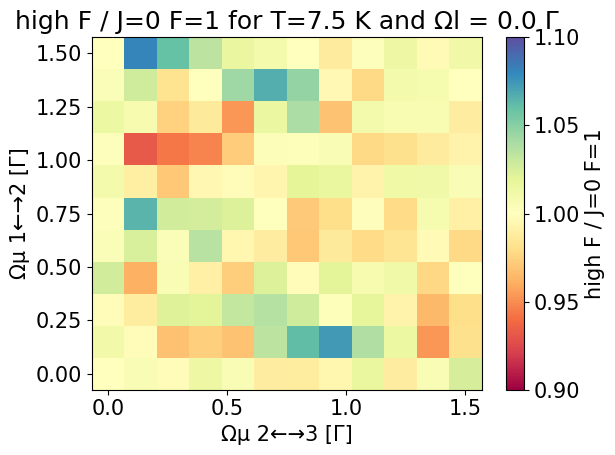

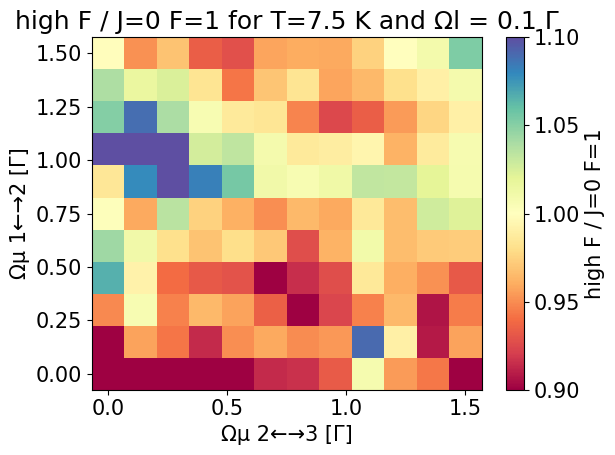

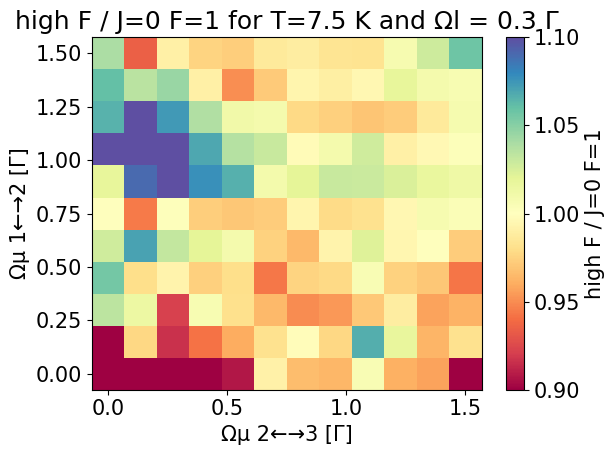

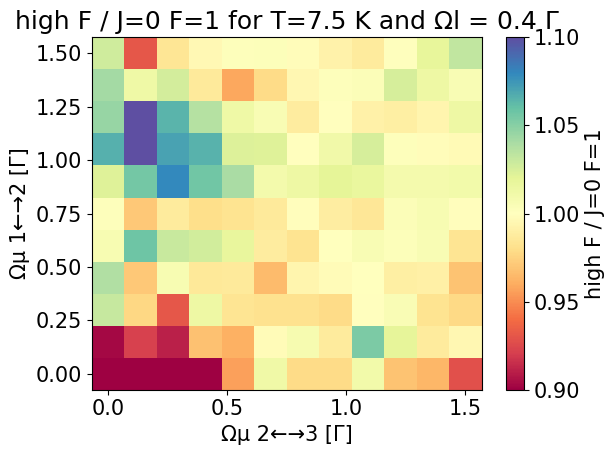

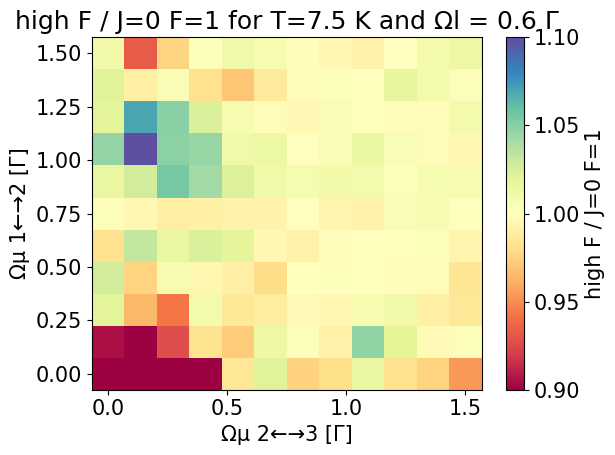

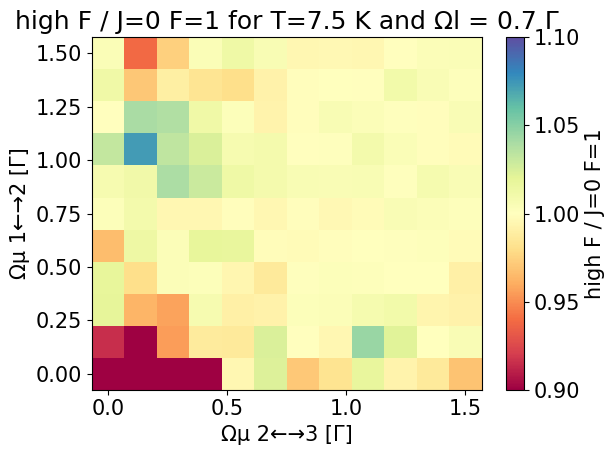

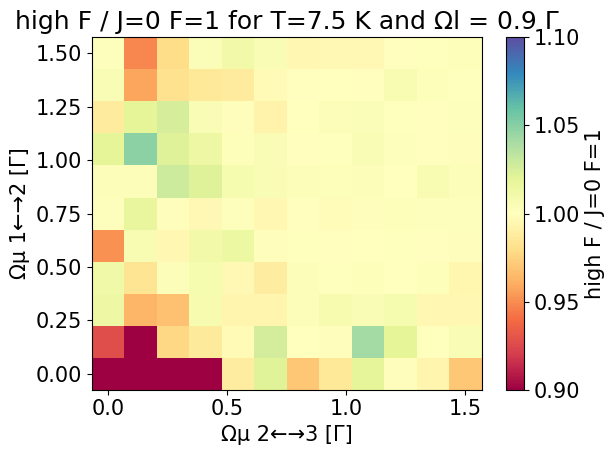

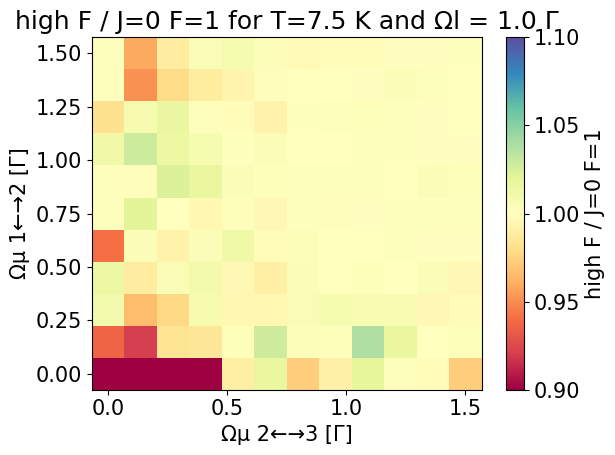

In [642]:
from matplotlib import colors

divnorm = colors.TwoSlopeNorm(vmin=0.9, vcenter=1, vmax=1.1)

X, Y = np.meshgrid(rabis_microwave_23, rabis_microwave_12, indexing="ij")

for idL, Ωl in enumerate(rabis_laser):
    # if idT % 2 == 0:
    #     continue

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(
        X / hamiltonian.Γ,
        Y / hamiltonian.Γ,
        (gain_from_depletion_high_F[:, :, idL] / gain_J0_F1[:, :, idL].mean(axis=-1)),
        norm=divnorm,
        cmap="Spectral",
    )
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("high F / J=0 F=1")
    ax.set_xlabel("Ωμ 2←→3 [Γ]")
    ax.set_ylabel("Ωμ 1←→2 [Γ]")
    ax.set_title(
        f"high F / J=0 F=1 for T=7.5 K and Ωl = {rabis_laser[idL]/hamiltonian.Γ:.1f} Γ"
    )
    fig.tight_layout()
    # ax.grid(True)